# Dependencies

In [ ]:
# installs
!pip install news-please
!pip install spacytextblob

In [3]:
import requests
from bs4 import BeautifulSoup
import pathlib
import textwrap
import requests
import os
import json
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob, Word

from newsplease import NewsPlease

import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sanka\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanka\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sanka\AppData\Roaming\nltk_data...


True

Loading Models and Extensions

In [ ]:
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm

# API Setup

Gemini Model and Rapid API

In [42]:
# getting gemini model
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

GOOGLE_API_KEY='__'
X_RapidAPI_Key='__'

genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

NewsNow Endpoint

In [6]:
url = "https://newsnow.p.rapidapi.com/newsv2"

payload = {
	"query": "Tesla",
	"time_bounded": True,
	"from_date": "01/02/2024",
	"to_date": "03/06/2024",
	"location": "us",
	"language": "en",
	"page": 1
}
headers = {
	"content-type": "application/json",
	"X-RapidAPI-Key": X_RapidAPI_Key,
	"X-RapidAPI-Host": "newsnow.p.rapidapi.com"
}

response = requests.post(url, json=payload, headers=headers)

print(response.json())

{'count': 10, 'page': 1, 'news': [{'title': 'Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax - Forbes', 'top_image': 'https://www.forbes.com/sites/brookecrothers/2024/02/04/hard-lesson-as-used-electric-vehicle-prices-crash-tesla-model-y-model-3-and-chevy-bolt-at-carmax//favicon.ico', 'images': [], 'videos': [], 'url': 'https://www.forbes.com/sites/brookecrothers/2024/02/04/hard-lesson-as-used-electric-vehicle-prices-crash-tesla-model-y-model-3-and-chevy-bolt-at-carmax/', 'date': 'Sun, 04 Feb 2024 08:00:00 GMT', 'short_description': 'Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax  Forbes', 'text': 'Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax  Forbes', 'publisher': {'href': 'https://www.forbes.com', 'title': 'Forbes'}}, {'title': 'Tesla 1Q profit falls 55%, but stock jumps as company moves to speed production of cheaper vehicles', '

In [7]:
# data extraction
data = response.json()
news_list = None

if 'news' in data:
    news_list = data['news']
    for news_item in news_list:

        title = news_item['title']
        top_image = news_item.get('top_image', 'No top image found')
        images = news_item.get('images', [])
        about = news_item.get('short_description')
        url = news_item.get('url')
        text = news_item.get('text')

        print("Title:", title)
        print("Top Image:", top_image)
        print("Additional Images:", images)
        print("About: ", about)
        print("URL: ", url)
        # print("TXT: ", text)
        print("-------------")
else:
    print("No news found in the response.")

Title: Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax - Forbes
Top Image: https://www.forbes.com/sites/brookecrothers/2024/02/04/hard-lesson-as-used-electric-vehicle-prices-crash-tesla-model-y-model-3-and-chevy-bolt-at-carmax//favicon.ico
Additional Images: []
About:  Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax  Forbes
URL:  https://www.forbes.com/sites/brookecrothers/2024/02/04/hard-lesson-as-used-electric-vehicle-prices-crash-tesla-model-y-model-3-and-chevy-bolt-at-carmax/
-------------
Title: Tesla 1Q profit falls 55%, but stock jumps as company moves to speed production of cheaper vehicles
Top Image: https://dims.apnews.com/dims4/default/dc61d67/2147483647/strip/true/crop/6000x3375+0+312/resize/1440x810!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2F56%2F2c%2Fb1b560ed7af8d79231b10034412d%2Fa52b7b00744841958eb7ed2861906644
Additional Images: ['https://dims.apnews.com/dims4/

Google News Endpoint

In [8]:
# Google News endpoint
keyword = "Tesla"
url = f"https://google-news13.p.rapidapi.com/search?keyword={keyword}"

querystring = {"lr":"en-US"}

headers = {
	"X-RapidAPI-Key": X_RapidAPI_Key,
	"X-RapidAPI-Host": "google-news13.p.rapidapi.com"
}

response2 = requests.get(url, headers=headers, params=querystring)

print(response2.json())

{'status': 'success', 'items': [{'title': 'More Tesla employees laid off as bloodbath enters its fourth week', 'snippet': 'Tesla entered its fourth week of layoffs with more employees reporting being let go over the weekend. The company has already slashed 10...', 'publisher': 'The Verge', 'timestamp': '1715013606000', 'newsUrl': 'https://www.theverge.com/2024/5/6/24150274/tesla-layoffs-employee-fourth-week-elon-musk-ev-demand', 'images': {'thumbnail': 'https://news.google.com/api/attachments/CC8iK0NnNWxZVkJrU0hwNFFWaGlha1ZTVFJDM0FSaVRBaWdCTWdZQmc0aUx1UVk=-w280-h168-p-df-rw', 'thumbnailProxied': 'https://i.zedtranslate.com/newsimage/CC8iK0NnNWxZVkJrU0hwNFFWaGlha1ZTVFJDM0FSaVRBaWdCTWdZQmc0aUx1UVk'}}, {'title': 'Elon Musk says Warren Buffett should buy Tesla shares', 'snippet': 'Elon Musk said on Sunday that Berkshire Hathaway CEO Warren Buffett should purchase a stake in electric vehicle maker Tesla, calling it an...', 'publisher': 'Fox Business', 'timestamp': '1715016120000', 'newsUrl'

```
Google News Response JSON: example
{'title': "Tesla's Supercharger layoffs couldn't have come at a worse time",
 'snippet': 'EV charger infrastructure projects are suddenly stalled without warning as emails to Tesla bounce and NACS adapters are getting delayed.',
 'publisher': 'The Verge',
 'timestamp': '1714758087000',
 'newsUrl': 'https://www.theverge.com/2024/5/3/24147402/tesla-supercharger-layoffs-stalled-ev-infrastructure-projects',
 'images': {'thumbnail': 'https://news.google.com/api/attachments/CC8iK0NnNDRUMjh5YVcwelNITmZTVnBXVFJDM0FSaVRBaWdCTWdZbGRwTHNMUWM=-...',
            'thumbnailProxied': 'https://i.zedtranslate.com/newsimage...'}}
```

In [9]:
# data extraction
data = response2.json()
# news_list = None

if 'items' in data:
    i = len(news_list)
    news_list.extend(data['items'])
    for news_item in news_list[i:]:
        title = news_item['title']
        top_image = news_item.get('top_image', 'No top image found')
        images = news_item.get('images', [])
        about = news_item.get('snippet')
        url = news_item.get('newsUrl')

        print("Title:", title)
        print("Top Image:", top_image)
        print("Additional Images:", images)
        print("About: ", about)
        print("URL: ", url)
        print("-------------")
else:
    print("No news found in the response.")

Title: More Tesla employees laid off as bloodbath enters its fourth week
Top Image: No top image found
Additional Images: {'thumbnail': 'https://news.google.com/api/attachments/CC8iK0NnNWxZVkJrU0hwNFFWaGlha1ZTVFJDM0FSaVRBaWdCTWdZQmc0aUx1UVk=-w280-h168-p-df-rw', 'thumbnailProxied': 'https://i.zedtranslate.com/newsimage/CC8iK0NnNWxZVkJrU0hwNFFWaGlha1ZTVFJDM0FSaVRBaWdCTWdZQmc0aUx1UVk'}
About:  Tesla entered its fourth week of layoffs with more employees reporting being let go over the weekend. The company has already slashed 10...
URL:  https://www.theverge.com/2024/5/6/24150274/tesla-layoffs-employee-fourth-week-elon-musk-ev-demand
-------------
Title: Elon Musk says Warren Buffett should buy Tesla shares
Top Image: No top image found
Additional Images: {'thumbnail': 'https://news.google.com/api/attachments/CC8iK0NnNVROMUJFUlZkcWVISkpXazR4VFJDb0FSaXNBaWdCTWdhZFlvTDFwQWc=-w280-h168-p-df-rw', 'thumbnailProxied': 'https://i.zedtranslate.com/newsimage/CC8iK0NnNVROMUJFUlZkcWVISkpXazR4VFJDb0FS

In [10]:
news_list[35]['newsUrl']

'https://www.coindesk.com/markets/2024/05/06/elon-musk-will-likely-remain-tesla-ceo-and-tweet-non-stop-prediction-markets/'

```
---------- NEWS Please article extraction JSON SAMPLE RESPONSE ----------
article =
{
  "authors": [],
  "date_download": null,
  "date_modify": null,
  "date_publish": "2017-07-17 17:03:00",
  "description": "Russia has called on Ukraine to ...",
  "filename": "https%3A%2F%2Fwww.rt.com%2Fnews%2F2 ...",
  "image_url": "https://img.rt.com/files/news/31/ ...",
  "language": "en",
  "localpath": null,
  "source_domain": "www.rt.com",
  "maintext": "Russia has called on Ukraine to stick ...",
  "title": "Moscow to Kiev: Stick to Minsk ceasefire ...",
  "title_page": null,
  "title_rss": null,
  "url": "https://www.rt.com/news/203203-ukraine-russia ..."
}
```

Formatting Data into One Uniform Structure

Ignore ```ERROR:newsplease.crawler.simple_crawler:not a 200 response: 40..``` message when running the cell below

In [11]:
# features needed: title, url OR newsUrl, publisher, text or maintext (NewsPlease), short description or snippet, date or timestamp
filter = []
for i, news_item in enumerate(news_list):
    dic = {'title': '', 'url': '', 'publisher': '', 'text': '', 'description': '', 'timestamp': ''}

    if 'text' in news_item:
        dic['text'] = news_item['text']
    else:
        article = NewsPlease.from_url(news_item['newsUrl'])
        dic['text'] = article.maintext if article else ''

    dic['title'] = news_item['title']
    dic['url'] = news_item['url'] if 'url' in news_item else news_item['newsUrl']
    dic['publisher'] = news_item['publisher']['href'] if 'text' in news_item else news_item['publisher']
    dic['description'] = news_item['short_description'] if 'short_description' in news_item else news_item['snippet']
    dic['timestamp'] = news_item['date'] if 'date' in news_item else news_item['timestamp']

    filter.append(dic)

news_list = filter

not a 200 response: 403
not a 200 response: 401
not a 200 response: 401
not a 200 response: 403
not a 200 response: 403
not a 200 response: 401
not a 200 response: 401
not a 200 response: 401
not a 200 response: 403
not a 200 response: 401
not a 200 response: 403
not a 200 response: 403
not a 200 response: 403
not a 200 response: 401


In [12]:
news_list[:5]

[{'title': 'Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax - Forbes',
  'url': 'https://www.forbes.com/sites/brookecrothers/2024/02/04/hard-lesson-as-used-electric-vehicle-prices-crash-tesla-model-y-model-3-and-chevy-bolt-at-carmax/',
  'publisher': 'https://www.forbes.com',
  'text': 'Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax  Forbes',
  'description': 'Hard Lesson As Used Electric Vehicle Prices Crash: Tesla Model Y, Model 3 And Chevy Bolt At CarMax  Forbes',
  'timestamp': 'Sun, 04 Feb 2024 08:00:00 GMT'},
 {'title': 'Tesla 1Q profit falls 55%, but stock jumps as company moves to speed production of cheaper vehicles',
  'url': 'https://apnews.com/article/tesla-future-sales-decline-robotaxi-artificial-intelligence-b60696cb69d7735983abcf51aee7f743',
  'publisher': 'https://apnews.com',
  'text': 'Tesla’s first-quarter net income plummeted 55%, but its stock price surged in afte

# Filtering & Processing Articles

In [13]:
# Limit amount of articles per publisher to 3 and filter articles with less than 100 tokens
filtered_news = []
amount = {}
i = 0
for news_item in news_list:
    if news_item['text'] is None:
      continue
    if len(news_item['text']) > 250:
      if news_item['publisher']:
        if news_item['publisher'] not in amount:
          amount[news_item['publisher']] = 0
        if amount[news_item['publisher']] < 3:
          #print(f"{len(news_item['text'])} {i}")
          amount[news_item['publisher']] += 1
          filtered_news.append(news_item)
    i += 1

news_list = filtered_news

Final Total number of articles Filtered

In [14]:
sum(amount.values())

66

# Setup Data Storage Structure

In [15]:
# document structure -> document = {[url]: {'paragraphs': [], 'sentences': [[], [], ...]}}
# each index in paragraphs is associated with the same index in sentences
# at any index in sentences, contains list of individual sentences of that paragraph at that idx
documents = {}

for news_item in news_list:
    title = news_item['title']
    url = news_item['url']
    txt = news_item['text']

    # since url unique and only once, intialize directly
    documents[url] = {'paragraphs': txt.split("\n\n"), 'sentences': []}

    for paragraph in documents[url]['paragraphs']:
        documents[url]['sentences'].append(tokenize.sent_tokenize(paragraph))

View Stored Documents' Format

In [78]:
# print 5 paragraphs, 5 sentences per paragraph for view simplicity
count = 0
for url in documents:
    count += 1
    print(url)
    for i, paragraph in enumerate(documents[url]['paragraphs'][:5]):
        print("\t", '\033[1m' + '\033[4m' + "Paragraph ->" + '\033[0m', paragraph)
        print("\t\t", '\033[1m' + '\033[4m' + "Sentences ->" + '\033[0m')
        for sentence in documents[url]['sentences'][i]:
            print("\t\t", sentence.strip())

    print("-"*80)
    if count >= 5:
        break


https://apnews.com/article/tesla-future-sales-decline-robotaxi-artificial-intelligence-b60696cb69d7735983abcf51aee7f743
	 Paragraph -> Tesla’s first-quarter net income plummeted 55%, but its stock price surged in after-hours trading Tuesday as the company said it would accelerate production of new, more affordable vehicles.
		 Sentences ->
		 Tesla’s first-quarter net income plummeted 55%, but its stock price surged in after-hours trading Tuesday as the company said it would accelerate production of new, more affordable vehicles.
	 Paragraph -> The Austin, Texas, company said it made $1.13 billion from January through March compared with $2.51 billion in the same period a year ago.
		 Sentences ->
		 The Austin, Texas, company said it made $1.13 billion from January through March compared with $2.51 billion in the same period a year ago.
	 Paragraph -> Investors and analysts were looking for some sign that Tesla will take steps to stem its stock’s slide this year and grow sales. The co

# Preprocess Texts and Predict Sentiment

Lemmatize the corpus and remove stop words

In [17]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = [Word(word.lower()).lemmatize() for word in text.split() if word.lower() not in stop_words and word.isalpha()]
    return " ".join(words)

In [18]:
def process_text(text):
    # Add special tokens for BERT
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    return inputs

In [19]:
def predict_sentiment(text):
    text = preprocess_text(text)
    inputs = process_text(text)  # process inputs to the model
    outputs = model(**inputs)
    logits = outputs.logits

    # Get the class labels from the model configuration
    class_labels = model.config.id2label  # Access the id2label dictionary

    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Combine labels and probabilities
    sentiment_results = list(zip(class_labels.values(), probabilities[0].tolist()))

    return predicted_class, sentiment_results

In [20]:
def map_label_to_score(label, probability):
    if label == 0:
        return -1.0 + (probability * 0.4)  # Extremely Neg (-1 to -0.6)
    elif label == 1:
        return -0.6 + (probability * 0.6)  # Neg (-0.6 to 0)
    elif label == 2:
        return probability * 0.3   # Neutral (0 to 0.3)
    elif label == 3:
        return 0.3 + (probability * 0.3)   # Pos (0.3 to 0.6)
    elif label == 4:
        return 0.6 + (probability * 0.4)   # Extremely Pos (0.6 to 1)

# Set up BERT Model for Sentiment Analysis

In [21]:
model_name = "kwang123/bert-sentiment-analysis"  # Replace with the model name you found
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

c:\Users\sanka\anaconda3\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sanka\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Analysis Method
1: (outer level) feed paragraphs <br>
2: average the polarity of paragraphs within the documnet -> returns sentiment of the document <br>
3: make threshold for selling and buying by analysing compound/polarity <br>

In [24]:
# BERT sentiment analysis --------------------------------
print("Sentiment Results:")

total_polarity = []
for url in documents:
    document_sentiments = []

    for i, paragraph in enumerate(documents[url]['paragraphs']):
        predicted_class, sentiment_results = predict_sentiment(paragraph)
        sentiment_score = map_label_to_score(predicted_class, sentiment_results[predicted_class][1])
        document_sentiments.append(sentiment_score)

    if document_sentiments:
        document_sentiment = sum(document_sentiments) / len(document_sentiments)

    print("")
    print("URL: ", url)
    print("Predicted Class =", predicted_class)
    for label, probability in sentiment_results:
        print(f" | {label}: {probability}", end=" ")
    print("")
    print("-"*200)

    total_polarity.append(document_sentiment)


Sentiment Results:

URL:  https://apnews.com/article/tesla-future-sales-decline-robotaxi-artificial-intelligence-b60696cb69d7735983abcf51aee7f743
Predicted Class = 2
 | Extremely Negative: 0.00039454310899600387  | Negative: 0.010756563395261765  | Neutral: 0.9714404940605164  | Positive: 0.01697659119963646  | Extremely Positive: 0.000431783584645018 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

URL:  https://edition.cnn.com/2024/04/02/business/tesla-sales/index.html
Predicted Class = 2
 | Extremely Negative: 0.00044892478035762906  | Negative: 0.011045892722904682  | Neutral: 0.9759794473648071  | Positive: 0.012037728913128376  | Extremely Positive: 0.0004879868938587606 
---------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
total_polarity

[0.38017971836603603,
 0.163406067385393,
 0.3387552157044411,
 0.28061553359031677,
 0.4891429960727691,
 0.9988257169723511,
 -0.6468777179718017,
 0.9987075328826904,
 0.9975473165512085,
 0.8245415210723877,
 0.9987574100494385,
 0.9988263368606567,
 -0.3281839907169342,
 0.5011874735355377,
 -0.24066013097763062,
 -0.7140066623687744,
 0.9986117601394653,
 0.9985638380050659,
 0.9986794710159301,
 0.9987240076065064,
 0.978687858581543,
 -0.009963619709014937,
 0.9986480236053467,
 0.29631473422050475,
 -0.16351593732833863,
 0.9987487077713013,
 -0.6016782045364379,
 0.9363157033920289,
 0.9987725734710693,
 0.9987362384796142,
 0.5368813276290894,
 0.4419353663921356,
 0.998662805557251,
 0.3950621902942657,
 0.9986570358276368,
 0.9986067771911621,
 0.5460568964481354,
 0.9987744808197021,
 0.9986754179000854,
 0.99865243434906,
 0.9987424850463867,
 0.9986649513244629,
 -0.601578664779663,
 -0.7671411037445068,
 0.9986463785171509,
 -0.03374108076095583,
 0.9211238622665405,
 

Unweighted Polarity Score

In [26]:
# Current final score
sum(total_polarity)/len(total_polarity)

0.5969096847439187

In [27]:
df = pd.DataFrame(news_list)
df['total_polarity'] = total_polarity
df

,title,url,publisher,text,description,timestamp,total_polarity
0,"Tesla 1Q profit falls 55%, but stock jumps as ...",https://apnews.com/article/tesla-future-sales-...,https://apnews.com,Tesla’s first-quarter net income plummeted 55%...,Tesla's first-quarter net income tumbles 55% ...,"Tue, 23 Apr 2024 07:00:00 GMT",0.380180
1,Tesla sales plunge far more than expected,https://edition.cnn.com/2024/04/02/business/te...,https://www.cnn.com,New York CNN —\n\nTesla posted its first annua...,Tesla sales plunge far more than expected CNN,"Tue, 02 Apr 2024 07:00:00 GMT",0.163406
2,Tesla Cybertruck No Match For Car Wash,https://jalopnik.com/tesla-cybertruck-no-match...,https://jalopnik.com,After just a couple of months and a few thousa...,Tesla Cybertruck No Match For Car Wash Jalopnik,"Wed, 17 Apr 2024 07:00:00 GMT",0.338755
3,Tesla (TSLA) launches another round of layoffs,https://electrek.co/2024/05/06/tesla-tsla-laun...,https://electrek.co,Tesla (TSLA) launched another round of layoffs...,Tesla (TSLA) launches another round of layoffs...,"Mon, 06 May 2024 15:26:00 GMT",0.280616
4,More Tesla employees laid off as bloodbath ent...,https://www.theverge.com/2024/5/6/24150274/tes...,The Verge,Tesla’s brutal round of layoffs entered its fo...,Tesla entered its fourth week of layoffs with ...,1715013606000,0.489143
...,...,...,...,...,...,...,...
61,Tesla's Supercharger layoffs couldn't have com...,https://www.theverge.com/2024/5/3/24147402/tes...,The Verge,Bounced emails. Stalled projects. Delayed adap...,EV charger infrastructure projects are suddenl...,1714758087000,0.986149
62,Cyber Stuck: First Tesla Cybertruck On Nantuck...,https://nantucketcurrent.com/news/cyber-stuck-...,Nantucket Current,The first Tesla Cybertruck to visit Nantucket ...,The first Tesla Cybertruck to visit Nantucket ...,1714707660000,-0.601865
63,As Questions Swirl Around Tesla's Supercharger...,https://www.wired.com/story/tesla-supercharger...,WIRED,In a move that shocked the electric vehicle in...,In a move that shocked the electric vehicle in...,1714609624000,0.925643
64,'I'm Still in Denial': Tesla Layoffs Leave Int...,https://www.thedailybeast.com/im-still-in-deni...,The Daily Beast,One New York college student was ready to spen...,One New York college student was ready to spen...,1714811667000,0.998704


Polarity Distribution

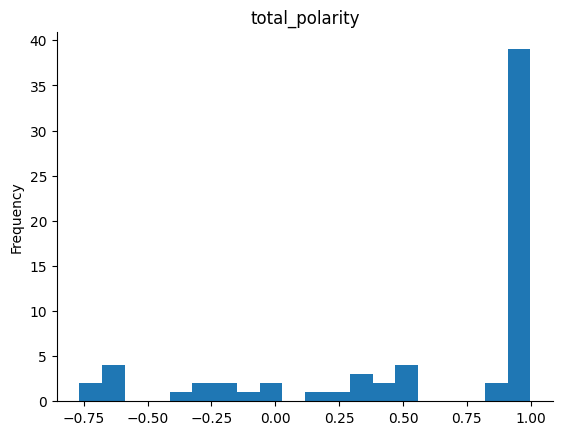

In [28]:
df['total_polarity'].plot(kind='hist', bins=20, title='total_polarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

Define weighted scores to emphasize negative scores and penalize positive scores to accomodate for model inaccuracies

In [31]:
# Define weight ranges for sentiment score
weight_ranges = {
    (-1.0, -0.6): 3.0,    # Extremely Neg
    (-0.6, 0.0): 2.5,     # Neg
    (0.0, 0.0): 0.9,      # Neutral
    (0.0, 0.6): 0.8,      # Pos
    (0.6, 1.0): 0.7       # Extremely Pos
}

# Calculate weighted sum of sentiment scores
weighted_sum = 0
total_weight = 0
for score in total_polarity:
    for score_range, weight in weight_ranges.items():
        if score_range[0] <= score <= score_range[1]:
            print("Document weighted score ", score * weight)
            weighted_sum += score * weight
            total_weight += weight
            break

# Calculate weighted average sentiment
weighted_average_sentiment = weighted_sum / total_weight

Document weighted score  0.3041437746928288
Document weighted score  0.13072485390831443
Document weighted score  0.2710041725635529
Document weighted score  0.22449242687225343
Document weighted score  0.39131439685821534
Document weighted score  0.6991780018806457
Document weighted score  -1.9406331539154051
Document weighted score  0.6990952730178832
Document weighted score  0.6982831215858459
Document weighted score  0.5771790647506713
Document weighted score  0.6991301870346069
Document weighted score  0.6991784358024596
Document weighted score  -0.8204599767923355
Document weighted score  0.4009499788284302
Document weighted score  -0.6016503274440765
Document weighted score  -2.1420199871063232
Document weighted score  0.6990282320976257
Document weighted score  0.698994686603546
Document weighted score  0.699075629711151
Document weighted score  0.6991068053245544
Document weighted score  0.68508150100708
Document weighted score  -0.024909049272537342
Document weighted score  0

Final average weighted sentiment of all articles

In [32]:
weighted_average_sentiment

0.21828914419678258

Detailed View with Spacy

In [33]:
# Load spaCy model with SpacyTextBlob extension
nlp = spacy.load("en_core_web_sm")
# Add SpacyTextBlob extension to the pipeline
nlp.add_pipe('spacytextblob')

In [36]:
detailed_info = []
for i, news_item in enumerate(news_list):
    dic = {'title': None, 'ngrams': None, 'subjectivity': None, 'sentiment_assessments': None}
    doc = nlp(news_item['text'])

    dic['title'] = news_item['title']
    dic['ngrams'] = doc._.blob.ngrams()
    dic['subjectivity'] = doc._.blob.subjectivity
    dic['sentiment_assessments'] = doc._.blob.sentiment_assessments.assessments
    detailed_info.append(dic)

# detailed_info

In [37]:
spacy_df = pd.DataFrame(detailed_info)
spacy_df

,title,ngrams,subjectivity,sentiment_assessments
0,"Tesla 1Q profit falls 55%, but stock jumps as ...","[[Tesla, ’, s], [’, s, first-quarter], [s, fir...",0.367677,"[([net], 0.0, 0.0, None), ([new], 0.1363636363..."
1,Tesla sales plunge far more than expected,"[[New, York, CNN], [York, CNN, —], [CNN, —, Te...",0.407020,"[([new], 0.13636363636363635, 0.45454545454545..."
2,Tesla Cybertruck No Match For Car Wash,"[[After, just, a], [just, a, couple], [a, coup...",0.448737,"[([few], -0.2, 0.1, None), ([effectively], 0.6..."
3,Tesla (TSLA) launches another round of layoffs,"[[Tesla, TSLA, launched], [TSLA, launched, ano...",0.349022,"[([round], -0.2, 0.4, None), ([pink], -0.1, 0...."
4,More Tesla employees laid off as bloodbath ent...,"[[Tesla, ’, s], [’, s, brutal], [s, brutal, ro...",0.410737,"[([brutal], -0.875, 1.0, None), ([round], -0.2..."
...,...,...,...,...
61,Tesla's Supercharger layoffs couldn't have com...,"[[Bounced, emails, Stalled], [emails, Stalled,...",0.352641,"[([absolutely, hard], -0.2916666666666667, 0.5..."
62,Cyber Stuck: First Tesla Cybertruck On Nantuck...,"[[The, first, Tesla], [first, Tesla, Cybertruc...",0.353144,"[([first], 0.25, 0.3333333333333333, None), ([..."
63,As Questions Swirl Around Tesla's Supercharger...,"[[In, a, move], [a, move, that], [move, that, ...",0.354068,"[([shocked], -0.7, 0.8, None), ([widely], -0.1..."
64,'I'm Still in Denial': Tesla Layoffs Leave Int...,"[[One, New, York], [New, York, college], [York...",0.422456,"[([new], 0.13636363636363635, 0.45454545454545..."


In [39]:
visualize_text = nlp(news_list[-1]['text'])
spacy.displacy.render(visualize_text, style="dep")

Comparing sentiments with Gemini Model

In [ ]:
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

In [43]:
def gemini_sentiment_analysis(text):
  question = f"I want you to perform a sentiment analysis on this text and give\
  me a sentiment score metric between -1 and 1 for scoring. \
  In your output, only give me the sentiment score: {text}"
  
  answer = model.generate_content(question)
  return answer.text

In [47]:
# Gemini sentiment analysis --------------------------------
print("Sentiment Results:")
print("")

gemini_total_polarity = []
for i, news_item in enumerate(news_list):
    sentiment_score = gemini_sentiment_analysis(news_item['text'])
    gemini_total_polarity.append(float(sentiment_score))

    print(f" URL: {news_item['url']} | Sentiment Score: {sentiment_score}")
    print("")
    print("-"*200)

Sentiment Results:

 URL: https://apnews.com/article/tesla-future-sales-decline-robotaxi-artificial-intelligence-b60696cb69d7735983abcf51aee7f743 | Sentiment Score: 0.26

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 URL: https://edition.cnn.com/2024/04/02/business/tesla-sales/index.html | Sentiment Score: -0.65

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 URL: https://jalopnik.com/tesla-cybertruck-no-match-for-car-wash-1851417011 | Sentiment Score: -0.3

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 URL: https://electrek.co

In [79]:
gemini_total_polarity

[0.26,
 -0.65,
 -0.3,
 -0.5,
 -0.6,
 0.05,
 -0.5,
 0.86,
 0.45,
 -0.5,
 -0.25,
 0.48,
 0.4,
 -0.5,
 -0.8,
 -0.5,
 0.4,
 0.2,
 -0.5,
 -0.25,
 0.05,
 -0.25,
 -0.06,
 0.0,
 -0.57,
 0.2833333333333333,
 0.6,
 -0.62,
 -0.2,
 0.7,
 -0.32,
 -0.6,
 0.96,
 -0.34,
 0.62,
 0.2,
 -0.2,
 0.25,
 -0.54,
 0.3,
 0.2,
 0.4,
 -0.8,
 -0.5,
 0.187,
 0.3,
 -0.7,
 -0.89,
 0.3903338,
 0.2,
 -0.4,
 -0.6,
 -0.55,
 -0.15,
 -0.06,
 -0.6,
 0.0,
 0.3,
 -0.15,
 -0.5,
 0.75,
 -0.55,
 0.04,
 -0.15,
 -0.82,
 -0.2]

Final Gemini Aggregated Sentiment Score

In [66]:
gemini_sentiment_score = sum(gemini_total_polarity)/len(gemini_total_polarity)
gemini_sentiment_score

-0.11120201313131314

Final Average Scoring of all Documents <br>
- While Gemini might be consistent in finding the sentiment category of the document, it is insconsistent in scoring the articles. For example, it could score the same article -0.2 first time and -0.4 second time around <br>
- While BERT is consistent in scoring the article approximately the same multiple times, it is not always correct in identifying the correct sentiment category <br>
- Taking these two big inconsistencies into account, we average the sentiment scores from Gemini and our BERT model to give a final Sentiment score to the list of articles regarding our target company <br>

In [73]:
final_sentiment = (gemini_sentiment_score + weighted_average_sentiment) / 2
print(f'Final Sentiment Score of all articles for {keyword}: {final_sentiment}')

Final Sentiment Score of all articles for Tesla: 0.05354356553273472


# Stock Prediction Decision

Decision based on the final calculated score <br>
Metric Ranges: <br>
- Buy [0.5 - 1] <br>
- Hold [0.2 - 0.5] <br>
- Sell [-1 to 0.2] <br>

Reason for varying range is because in reality, the more data we have the better. But in this case we are restricted by the amount of articles we are able to extract and process through our endpoints

In [74]:
ranges = {(-1, 0.2): 'Sell', (0.200001, 0.49999): 'Hold', (0.5, 1): 'Buy'}

for lower, upper in ranges:
    if lower <= final_sentiment <= upper:
        print("Prediction -> ", ranges[(lower, upper)], keyword)
        break


Prediction ->  Sell Tesla
